# SpatialDE

**SpatialDE** is a method to identify genes which significantly depend on spatial coordinates in non-linear and non-parametric ways. The intended applications are spatially resolved RNA-sequencing from e.g. Spatial Transcriptomics, or _in situ_ gene expression measurements from e.g. SeqFISH or MERFISH.

Additionally, SpatialDE provides **automatic expression histology**, a method that groups genes into common spatial patterns (and conversely reveal histological patterns based on gene coexpression).

This repository contains both the implementations of our methods, as well as case studies in applying it.

The key features of our method are

  - Unsupervised - No need to define spatial regions
  - Non-parametric and non-linear expression patterns
  - Automatic histology based on spatially coexpressed genes
  - Extremely fast - Transcriptome wide tests takes only a few minutes on normal computers
  
The primary implementation is as a Python 3 package, and can be installed from the command line by 

```
$ pip install spatialde
```

To see usage example of SpatialDE either keep reading, or look in the `Analysis` directory. The following examples are provided:

  - `BreastCancer` - Transcriptome wide study on breast cancer tissue from Spatial Transcriptomics.
  - `Frog` - A time course of RNA-seq ("1-d space") of _Xenopus_ development.
  - `MERFISH` - Expression from single cells in a region of an osteoblast culture using the MERFISH technology with 140 probes.
  - `MouseOB` - Spatial Transcriptomics assay of a slice of Mouse Olfactory Bulb. (Also see below).
  - `SeqFISH` - Expression counts of single cells from mouse hippocampus using the SeqFISH technology with 249 probes.

Below follows a typical usage example in interactive form.

## SpatialDE significance test example use

In [1]:
%pylab inline
import pandas as pd

rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False

import NaiveDE
import SpatialDE

Populating the interactive namespace from numpy and matplotlib


As an example, let us look at spatially dependent gene expression in Mouse Olfactory Bulb using a data set published in [Stahl et al 2016](http://dx.doi.org/10.1126/science.aaf2403). With the authors method, hundrads of locations on a tissue slice can be sampled at once, and gene expression is measured by sequencing in an unbiased whole-transcriptome manner.

In [2]:
counts = pd.read_csv('Analysis/MouseOB/data/Rep11_MOB_0.csv', index_col=0)
counts = counts.T[counts.sum(0) >= 3].T  # Filter practically unobserved genes

print(counts.shape)
counts.iloc[:5, :5]

(262, 14859)


,Nrf1,Zbtb5,Ccnl1,Lrrfip1,Bbs1
16.92x9.015,1,1,1,2,1
16.945x11.075,0,0,3,2,2
16.97x10.118,0,1,1,0,0
16.939x12.132,1,0,1,0,4
16.949x13.055,0,0,0,3,0


In [3]:
sample_info = pd.read_csv('Analysis/MouseOB/MOB_sample_info.csv', index_col=0)
counts = counts.loc[sample_info.index]  # Align count matrix with metadata table

sample_info.head(5)

,x,y,total_counts
16.92x9.015,16.920,9.015,18790
16.945x11.075,16.945,11.075,36990
16.97x10.118,16.970,10.118,12471
16.939x12.132,16.939,12.132,22703
16.949x13.055,16.949,13.055,18641


We can plot the x and y coordinates in the sample info table to see which locations of the tissue slice has been sampled.

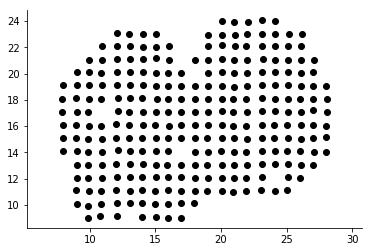

In [4]:
figsize(6, 4)
plt.scatter(sample_info['x'], sample_info['y'], c='k');
plt.axis('equal');

Our method assumes normally distributed noise, but the data we are using is from expression counts, and empirically seems to follow a negative binomial distribution. We use technique by Anscombe to approximately transform the data to normal distributed noise.

Secondly, library size or sequencing depth of the spatial samples will bias the expression of every gene. We use linear regression to account for this effect before performing the spatial test.

In [5]:
norm_expr = NaiveDE.stabilize(counts.T).T
resid_expr = NaiveDE.regress_out(sample_info, norm_expr.T, 'np.log(total_counts)').T

For the sake of this example, let's just run the test on 1000 random genes. This should just take a few seconds. With our very fast implementation, testing all 14,000 genes takes about 10 minutes.

In [6]:
sample_resid_expr = resid_expr.sample(n=1000, axis=1, random_state=1)

X = sample_info[['x', 'y']]
results = SpatialDE.run(X, sample_resid_expr)

INFO:root:Performing DE test
INFO:root:Pre-calculating USU^T = K's ...
INFO:root:Done: 0.11s
INFO:root:Fitting gene models
INFO:root:Model 1 of 10
INFO:root:Model 2 of 10                            
INFO:root:Model 3 of 10                            
INFO:root:Model 4 of 10                            
INFO:root:Model 5 of 10                            
INFO:root:Model 6 of 10                            
INFO:root:Model 7 of 10                            
INFO:root:Model 8 of 10                            
INFO:root:Model 9 of 10                            
INFO:root:Model 10 of 10                           


The result will be a `DataFrame` with P-values and other relevant values for each gene.

The most important columns are

  - `g` - The name of the gene
  - `pval` - The P-value for spatial differential expression
  - `qval` - Signifance after correcting for multiple testing
  - `l` - A parameter indicating the distance scale a gene changes expression over

In [7]:
results.head().T

,0,1,2,3,4
FSV,0.999955,2.0597e-09,2.0597e-09,2.0597e-09,2.0597e-09
M,4,4,4,4,4
g,2410016O06Rik,Arpp19,Srsf7,Wbp7,Cpsf3l
l,0.402001,0.402001,0.402001,0.402001,0.402001
max_delta,4.53999e-05,4.85165e+08,4.85165e+08,4.85165e+08,4.85165e+08
max_ll,-52.2589,-107.685,-114.477,-112.664,-49.1672
max_mu_hat,-0.826851,-2.21845,-6.67811,-2.25044,0.146089
max_s2_t_hat,0.666985,1.04203e-08,9.22126e-08,1.07257e-08,2.20142e-10
model,SE,SE,SE,SE,SE
n,260,260,260,260,260


In [8]:
results.sort_values('qval').head(10)[['g', 'l', 'qval']]

,g,l,qval
890,Kcnh3,1.907609,0.001512
772,Pcp4,1.135190,0.013843
736,Igfbp2,1.135190,0.013843
800,Gng13,1.907609,0.022632
646,Naaa,0.675535,0.051705
749,Map1b,1.135190,0.051705
826,Gng4,1.907609,0.051705
724,Fmo1,1.135190,0.096710
714,Slc38a3,1.135190,0.096710
712,Hpcal4,1.135190,0.107360


We detected a few spatially differentially expressed genes, _Cck_ and _Ptn_ for example.

A simple way to visualize these genes is by plotting the x and y coordinates as above, but letting the color correspond to expression level.

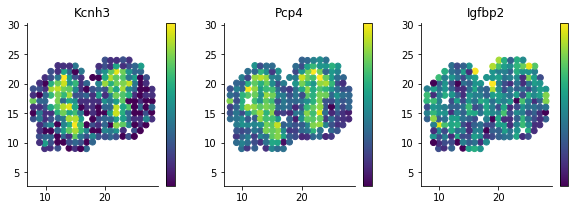

In [9]:
figsize(10, 3)
for i, g in enumerate(['Kcnh3', 'Pcp4', 'Igfbp2']):
    plt.subplot(1, 3, i + 1)
    plt.scatter(sample_info['x'], sample_info['y'], c=norm_expr[g]);
    plt.title(g)
    plt.axis('equal')

    
    plt.colorbar(ticks=[]);

For reference, we can compare these to genes which are not spatially DE

In [10]:
results.sort_values('qval').tail(10)[['g', 'l', 'qval']]

,g,l,qval
334,Tmem70,0.402001,0.975231
335,Rnf20,0.402001,0.975231
336,Zfp85-rs1,0.402001,0.975231
337,C1qtnf7,0.402001,0.975231
338,Ap4b1,0.402001,0.975231
339,Psma4,0.402001,0.975231
340,Aldh3b1,0.402001,0.975231
341,Hdx,0.402001,0.975231
328,Zfp113,0.402001,0.975231
999,Preb,9.052138,0.975231


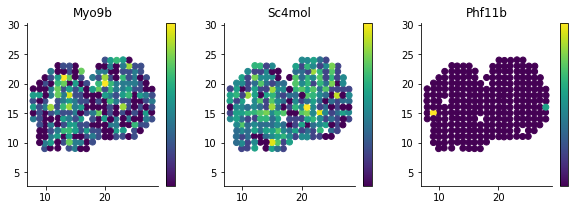

In [11]:
figsize(10, 3)
for i, g in enumerate(['Myo9b', 'Sc4mol', 'Phf11b']):
    plt.subplot(1, 3, i + 1)
    plt.scatter(sample_info['x'], sample_info['y'], c=norm_expr[g]);
    plt.title(g)
    plt.axis('equal')

    
    plt.colorbar(ticks=[]);

In regular differential expression analysis, we usually investigate the relation between significance and effect size by so called _volcano plots_. We don't have the concept of fold change in our case, but we can investigate the fraction of variance explained by spatial variation.

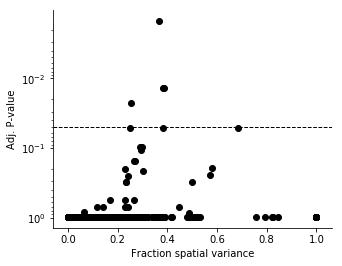

In [12]:
figsize(5, 4)
plt.yscale('log')

plt.scatter(results['FSV'], results['qval'], c='black')

plt.axhline(0.05, c='black', lw=1, ls='--');

plt.gca().invert_yaxis();
plt.xlabel('Fraction spatial variance')
plt.ylabel('Adj. P-value');

## Automatic expression histology

To perform automatic expression histology (AEH), the genes should be filtered by SpatialDE significance. For this example, let us use a very weak threshold. But in typical use, filter by `qval < 0.05`

In [13]:
sign_results = results.query('qval < 0.5')

AEH requires two parameters: the number of patterns, and the characteristic lengthscale for histological patterns.

For some guidance in picking the lengthscale `l` we can look at the optimal lengthscale for the signficant genes.

In [14]:
sign_results['l'].value_counts()

1.135190    11
1.907609     4
0.675535     4
3.205604     1
Name: l, dtype: int64

Here we see that the lengthscale on average is ~1.5, to use some extra spatial covariance, we put this paramater to `l = 1.8`.

For the number of patterns, we try `C = 3`.

In [15]:
histology_results, patterns = SpatialDE.aeh.spatial_patterns(X, resid_expr, sign_results, C=3, l=1.8, verbosity=1)

iter 0, ELBO: -9.48e+08
iter 1, ELBO: -4.20e+08, delta_ELBO: 5.28e+08
iter 2, ELBO: -4.20e+08, delta_ELBO: 7.63e+02
iter 3, ELBO: -4.20e+08, delta_ELBO: 2.07e+02
iter 4, ELBO: -4.20e+08, delta_ELBO: 8.03e+01
iter 5, ELBO: -4.20e+08, delta_ELBO: 3.40e+00
iter 6, ELBO: -4.20e+08, delta_ELBO: 6.62e-02
iter 7, ELBO: -4.20e+08, delta_ELBO: 2.75e-03
iter 8, ELBO: -4.20e+08, delta_ELBO: 3.96e-03
iter 9, ELBO: -4.20e+08, delta_ELBO: 7.49e-05
Converged on iter 9


After fitting the AEH model, the function returns two `DataFrame`s, one with pattern membership information for each gene:

In [16]:
histology_results.head()

,g,membership,pattern
564,AI593442,1.0,1
619,Arhgef9,1.0,1
632,6330403K07Rik,1.0,1
646,Naaa,1.0,0
712,Hpcal4,1.0,2


And one with realizations for the underlying expression for each histological pattern.

We can visualize this underlying expression in the tissue context as we would for any individual gene.

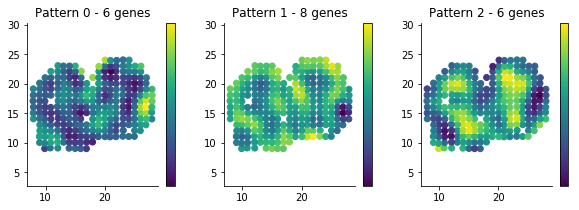

In [17]:
figsize(10, 3)
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.scatter(sample_info['x'], sample_info['y'], c=patterns[i]);
    plt.axis('equal')
    plt.title('Pattern {} - {} genes'.format(i, histology_results.query('pattern == @i').shape[0] ))
    plt.colorbar(ticks=[]);

It is usually interesting to see what the coexpressed genes determining a histological pattern are:

In [18]:
for i in histology_results.sort_values('pattern').pattern.unique():
    
    print('Pattern {}'.format(i))
    print(', '.join(histology_results.query('pattern == @i').sort_values('membership')['g'].tolist()))
    print()

Pattern 0
Naaa, Aebp1, Mfap3l, Fmo1, 2810002D19Rik, Gng13

Pattern 1
Map2, Arhgef9, AI593442, 6330403K07Rik, Slc38a3, Igfbp2, Nmb, Map1b

Pattern 2
Hpcal4, Snap25, Pcp4, Gng4, Ppfia2, Kcnh3

